In [1]:
import time
import pickle
import numpy as np
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [4]:
data = read_csv('csvs/preprocessed_data.csv')

In [5]:
data.drop(['Memory_Flash', 'Memory_HDD', 'Memory_Hybrid', 'TouchScreen', 'Weight', 'IPS_Panel', 'Inches'], axis = 1, inplace = True)
X = data.drop('Price', axis = 1)
Y = data['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1001, 8), (251, 8), (1001,), (251,))

In [6]:
display(data.head())

,Company,TypeName,RAM,OpSys,Price,CPU_Brand,CPU_Frequency,GPU,Memory_SSD
0,Apple,Ultrabook,8,Mac_OS,1339.69,Intel Core i5,2.3,Intel,128
1,Apple,Ultrabook,8,Mac_OS,898.94,Intel Core i5,1.8,Intel,0
2,HP,Notebook,8,Linux/No_OS/Other_OS,575.00,Intel Core i5,2.5,Intel,256
3,Apple,Ultrabook,16,Mac_OS,2537.45,Intel Core i7,2.7,AMD,512
4,Apple,Ultrabook,8,Mac_OS,1803.60,Intel Core i5,3.1,Intel,256


In [7]:
column_encoder = make_column_transformer(
    (OneHotEncoder(), ['Company', 'TypeName', 'OpSys', 'CPU_Brand', 'GPU']),
    remainder = 'passthrough'
)

In [8]:
quantile_transformer = QuantileTransformer(n_quantiles = 100)
non_linearizer = PolynomialFeatures(degree = 1)

In [9]:
xgb_regressor = XGBRegressor(n_estimators = 100, subsample = 0.75, reg_alpha = 10, min_split_loss = 10, reg_lambda = 2, max_depth = 10, min_child_weight = 1)
rnd_regressor = RandomForestRegressor()

In [10]:
XGB_model = make_pipeline(
    column_encoder,
    quantile_transformer,
    non_linearizer,
    xgb_regressor
)
RND_model = make_pipeline(
    column_encoder,
    quantile_transformer,
    non_linearizer,
    rnd_regressor
)

In [11]:
XGB_model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Company', 'TypeName',
                                                   'OpSys', 'CPU_Brand',
                                                   'GPU'])])),
                ('quantiletransformer', QuantileTransformer(n_quantiles=100)),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None,...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min_child_weight=1,
                              min_split_loss=10, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

In [12]:
RND_model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Company', 'TypeName',
                                                   'OpSys', 'CPU_Brand',
                                                   'GPU'])])),
                ('quantiletransformer', QuantileTransformer(n_quantiles=100)),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('randomforestregressor', RandomForestRegressor())])

In [13]:
display(X_test.head())

,Company,TypeName,RAM,OpSys,CPU_Brand,CPU_Frequency,GPU,Memory_SSD
895,HP,Gaming,8,Windows_10,Intel Core i5,2.3,Nvidia,128
742,Acer,Notebook,4,Windows_10,Intel Core i3,2.4,Intel,128
1134,Acer,Notebook,4,Windows_10,Other Intel Processor,2.0,Intel,0
784,MSI,Gaming,8,Windows_10,Intel Core i5,2.5,Nvidia,256
783,Lenovo,Ultrabook,8,Windows_10,Intel Core i7,2.7,Intel,512


In [14]:
y_train_predict = RND_model.predict(X_train)
error_train = mean_absolute_percentage_error(Y_train, y_train_predict)

y_test_predict = RND_model.predict(X_test)
error_test = mean_absolute_percentage_error(Y_test, y_test_predict)

In [15]:
print('RandomForestRegressorRegressor()')
print(f'MAPE on train data is {round(error_train*100, 2)}%')
print(f'MAPE on test data is {round(error_test*100, 2)}%')

RandomForestRegressorRegressor()
MAPE on train data is 9.87%
MAPE on test data is 19.12%


Text(0, 0.5, 'Y_train_predicted')

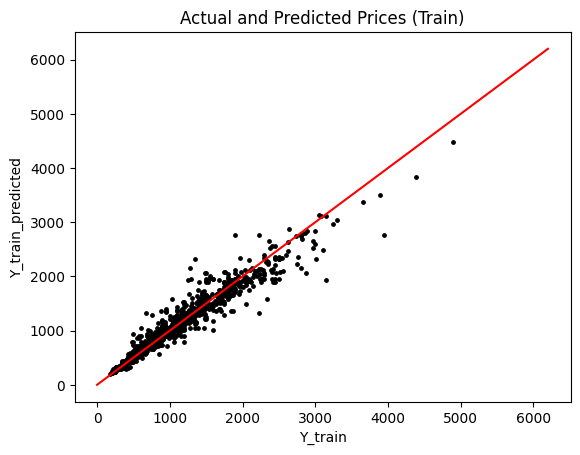

In [16]:
plt.scatter(Y_train, y_train_predict, color = 'black', s = 6)
plt.plot([0, 3500, 5500, 6200], [0, 3500, 5500, 6200], color = 'red')
plt.title('Actual and Predicted Prices (Train)')
plt.xlabel('Y_train')
plt.ylabel('Y_train_predicted')

Text(0, 0.5, 'Y_test_predicted')

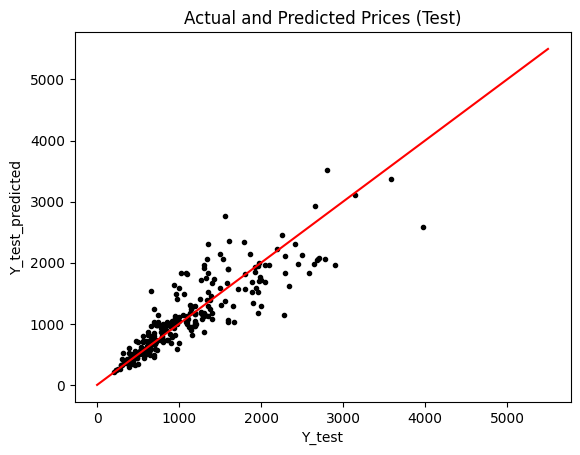

In [17]:
plt.scatter(Y_test, y_test_predict, color = 'black', s = 9)
plt.plot([0, 3500, 5500], [0, 3500, 5500], color = 'red')
plt.title('Actual and Predicted Prices (Test)')
plt.xlabel('Y_test')
plt.ylabel('Y_test_predicted')

In [18]:
y_train_predict = XGB_model.predict(X_train)
error_train = mean_absolute_percentage_error(Y_train, y_train_predict)

y_test_predict = XGB_model.predict(X_test)
error_test = mean_absolute_percentage_error(Y_test, y_test_predict)

In [19]:
print('XGBRegressor()')
print(f'MAPE on train data is {round(error_train*100, 2)}%')
print(f'MAPE on test data is {round(error_test*100, 2)}%')

XGBRegressor()
MAPE on train data is 6.55%
MAPE on test data is 19.56%


Text(0, 0.5, 'Y_train_predicted')

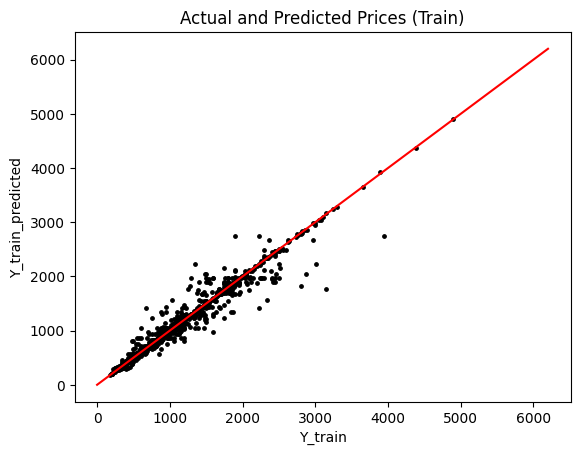

In [20]:
plt.scatter(Y_train, y_train_predict, color = 'black', s = 6)
plt.plot([0, 3500, 5500, 6200], [0, 3500, 5500, 6200], color = 'red')
plt.title('Actual and Predicted Prices (Train)')
plt.xlabel('Y_train')
plt.ylabel('Y_train_predicted')

Text(0, 0.5, 'Y_test_predicted')

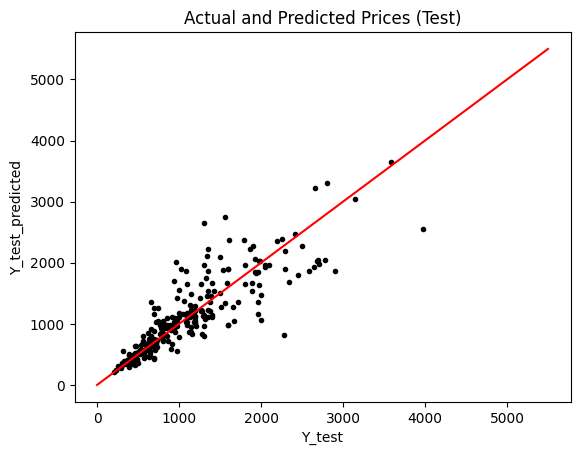

In [21]:
plt.scatter(Y_test, y_test_predict, color = 'black', s = 9)
plt.plot([0, 3500, 5500], [0, 3500, 5500], color = 'red')
plt.title('Actual and Predicted Prices (Test)')
plt.xlabel('Y_test')
plt.ylabel('Y_test_predicted')

In [22]:
XGB_model.fit(X, Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Company', 'TypeName',
                                                   'OpSys', 'CPU_Brand',
                                                   'GPU'])])),
                ('quantiletransformer', QuantileTransformer(n_quantiles=100)),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None,...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min_child_weight=1,
                              min_split_loss=10, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

In [23]:
with open('outputs/laptop_model.pkl', 'wb') as f:
    pickle.dump(XGB_model, f)
print(f"Model saved")

Model saved


Rest of the code is not used.<br>
Just mentioned here for refrence.

In [129]:
XGB_model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder', OneHotEncoder(),
                                    ['Company', 'TypeName', 'OpSys', 'CPU_Brand',
                                     'GPU'])])),
  ('quantiletransformer', QuantileTransformer(n_quantiles=100)),
  ('polynomialfeatures', PolynomialFeatures(degree=1)),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=Non

In [130]:
column_encoder = make_column_transformer(
    (OneHotEncoder(), ['Company', 'TypeName', 'OpSys', 'CPU_Brand', 'GPU']),
    remainder = 'passthrough'
)
quantile_transformer = QuantileTransformer()
non_linearizer = PolynomialFeatures()
xgb_regressor = XGBRegressor()

XGB_model = make_pipeline(
    column_encoder,
    quantile_transformer,
    non_linearizer,
    xgb_regressor
)

In [132]:
Grid = GridSearchCV(estimator = XGB_model,
                    param_grid ={
                        'polynomialfeatures__degree': [1, 2, 3],
                        'quantiletransformer__n_quantiles' : [25, 30, 35],
                        'xgbregressor__n_estimators' : [30, 35, 40],
#                         'xgbregressor__max_depth' : np.arange(1, 11, 6),
#                         'xgbregressor__eta' : [0.01, 0.1, 1],
#                         'xgbregressor__subsample' : np.linspace(0, 1, 5),
#                         'xgbregressor__colsample_bytree' : np.linspace(0, 1, 5)
                    },
                    scoring = 'neg_mean_squared_error',
                    refit = 'neg_mean_squared_error',
                    cv = 2)
print('Performing Grid search')
print('Please wait...')

time_1 = time.process_time()
Grid.fit(df, Y)
time_2 = time.process_time()
run_time = time_2 - time_1

print('Successfully performed Grid search')
print(f'Total Grid fit and search time : {run_time} seconds')
Result = DataFrame(Grid.cv_results_)
file_name = 'Result_grid.xlsx'
Result.to_excel(f'outputs/{file_name}')
print(f'Result saved in current directory as \"{file_name}\"', end = '\n\n')
print(f'The best search-parameters are {Grid.best_params_}')

Performing Grid search
Please wait...
Successfully performed Grid search
Total Grid fit and search time : 27.359375 seconds
Result saved in current directory as "Result_grid.xlsx"

The best search-parameters are {'polynomialfeatures__degree': 1, 'quantiletransformer__n_quantiles': 35, 'xgbregressor__n_estimators': 35}
